# **1. Helper Functions & Imports**

In [ ]:
# Necessary Imports
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import *
from torchvision import datasets, models, transforms
from torchsummary import summary
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ 
    Returns a path name for the model consisting of all the hyperparameter values.

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size
                                                   ,
                                                   learning_rate,
                                                   epoch)
    return path


def normalize_label(labels):
    """
    Returns a normalized label given a tensor containing 2 possible values.

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        tensor: A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)//(max_val - min_val)
    return norm_labels


def evaluate(net, loader, criterion):
    """ 
    Evaluates the network on a dataset.

    Args:
        net: PyTorch neural network object
        loader: PyTorch data loader for the validation set
        criterion: The loss function
    Returns:
        err: A scalar for the avg classification error over the validation set
        loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        # Convert labels to 0/1
        labels = normalize_label(labels) 
        if use_cuda and torch.cuda.is_available():
            inputs= inputs.cuda()
            labels = labels.cuda()
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss


def plot_training_curve(path):
    """ 
    Plots the training curve for a model run, given the .csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err)
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [ ]:
def evaluate_all(net, loader, criterion):
    """ 
    Evaluates the network on a dataset.

    Args:
        net: PyTorch neural network object
        loader: PyTorch data loader for the validation set
        criterion: The loss function
    Returns:
        err: A scalar for the avg classification error over the validation set
        loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        # Convert labels to 0/1
        #newlabels=torch.tensor([])
        #print(type(labels))
        #for i in labels:
              #if i < 2:
              #  newlabels=torch.cat((newlabels,torch.tensor([0]).float()),0)
              #else:
                #newlabels=torch.cat((newlabels,torch.tensor([1]).float()),0)
        if use_cuda and torch.cuda.is_available():
            inputs= inputs.cuda()
            labels = labels.cuda()
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

# **2. Data Loading and Splitting**

3,750 for final testing (15%)
3,750 for final validation (15%)
17,500 for training and preparation of CNNs

For each CNN --> select relevant images for your classification
12,250 images for training (10%)
2,625 for validation (15%)
2,625 for testing (15%)

In [ ]:
#Data Loading from Kaggle
! pip install -q kaggle


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"elysiaharrison","key":"91ae62bbd885ac43f3f2215c8fe02514"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

100% 1.75G/1.76G [00:27<00:00, 89.3MB/s]
100% 1.76G/1.76G [00:28<00:00, 67.4MB/s]


In [ ]:
!unzip '/content/lung-and-colon-cancer-histopathological-images.zip' -d '/root/datasets'

Streaming output truncated to the last 5000 lines.
  inflating: /root/datasets/lung_colon_image_set/lung_image_sets/lung_scc/lungscc10.jpeg  
  inflating: /root/datasets/lung_colon_image_set/lung_image_sets/lung_scc/lungscc100.jpeg  
  inflating: /root/datasets/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1000.jpeg  
  inflating: /root/datasets/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1001.jpeg  
  inflating: /root/datasets/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1002.jpeg  
  inflating: /root/datasets/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1003.jpeg  
  inflating: /root/datasets/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1004.jpeg  
  inflating: /root/datasets/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1005.jpeg  
  inflating: /root/datasets/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1006.jpeg  
  inflating: /root/datasets/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1007.jpeg  
  inflating: /root/dat

In [ ]:
! mkdir /root/datasets/lungcolondata

In [ ]:
!cp -r "/root/datasets/lung_colon_image_set/colon_image_sets/colon_aca" "/root/datasets/lungcolondata/"
!cp -r "/root/datasets/lung_colon_image_set/colon_image_sets/colon_n" "/root/datasets/lungcolondata/"
!cp -r "/root/datasets/lung_colon_image_set/lung_image_sets/lung_aca" "/root/datasets/lungcolondata/"
!cp -r "/root/datasets/lung_colon_image_set/lung_image_sets/lung_n" "/root/datasets/lungcolondata/"
!cp -r "/root/datasets/lung_colon_image_set/lung_image_sets/lung_scc" "/root/datasets/lungcolondata/"


In [ ]:
main_directory='/root/datasets/lungcolondata'
# classes are folders in each directory with these names
classes = ['colon_aca', 'colon_n', 'lung_aca','lung_n', 'lung_scc']

In [ ]:
! pip install split-folders tqdm

In [ ]:
import split_folders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
split_folders.ratio(main_directory, output="output", seed=1337, ratio=(.7, .15, .15))

Copying files: 25000 files [00:41, 608.32 files/s]


In [ ]:
all_test_dir='/content/output/test'
split_folders.ratio(all_test_dir, output="all_test", seed=1337, ratio=(.5,.5))

Copying files: 3750 files [00:06, 563.83 files/s]


In [ ]:
#The testing images for individual modules are under 'train' and final whole process testing under 'val'

In [ ]:
#! mkdir /content/class_loaders
#! mkdir /content/class_loaders/0
#! mkdir /content/class_loaders/1
#! mkdir /content/class_loaders/2
#! mkdir /content/class_loaders/3
#! mkdir /content/class_loaders/4

In [ ]:
#!cp -r "/content/output/train/colon_n/" "/content/class_loaders/0"
#!cp -r "/content/output/train/colon_aca/" "/content/class_loaders/1"
#!cp -r "/content/output/train/lung_scc/" "/content/class_loaders/2"
#!cp -r "/content/output/train/lung_aca/" "/content/class_loaders/3"
#!cp -r "/content/output/train/lung_n/" "/content/class_loaders/4"

In [ ]:
#colben_dir='/content/class_loaders/0'
#colmal_dir='/content/class_loaders/1'
#lungscc_dir='/content/class_loaders/2'
#lungaca_dir='/content/class_loaders/3'
#lungbenign_dir='/content/class_loaders/4'


In [ ]:
data_dir = '/content/output'
train_dir = os.path.join(data_dir, 'train/')
val_dir = os.path.join(data_dir, 'val/')
#test_dir = os.path.join(data_dir, 'test')

# resize all images to 224 x 224
data_transform = transforms.Compose([transforms.Resize((224,224)), 
                                transforms.ToTensor()])
no_resize = transforms.Compose([transforms.ToTensor()])
with_norm=transforms.Compose([transforms.Resize((224,224)), 
                                transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

print_data= datasets.ImageFolder(train_dir, transform=no_resize) #NO TRANSFORM
print2_data= datasets.ImageFolder(train_dir, transform=with_norm) #NORMALIZATION

train_data = datasets.ImageFolder(train_dir, transform=with_norm)
val_data = datasets.ImageFolder(val_dir, transform=data_transform)



#colbenign_data= datasets.ImageFolder(colben_dir, transform=data_transform)
#colmal_data= datasets.ImageFolder(colmal_dir, transform=data_transform)
#lungscc_data=datasets.ImageFolder(lungscc_dir, transform=data_transform)
#lungaca_data=datasets.ImageFolder(lungaca_dir, transform=data_transform)
#lungbenign_data=datasets.ImageFolder(lungbenign_dir, transform=data_transform)

print('Num training images: ', len(train_data))
print('Num validation images: ', len(val_data))
#print('Num test images:', len(test_data))

Num training images:  17500
Num validation images:  3750


In [ ]:
# Prepare Dataloader
batch_size = 27
num_workers = 1

print_loader = torch.utils.data.DataLoader(print_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=False) #NO TRANSFORM

print2_loader = torch.utils.data.DataLoader(print2_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=False) #NORMALIZATION

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)



#colbenign_loader=torch.utils.data.DataLoader(colbenign_data, batch_size=batch_size, 
                                           #num_workers=num_workers, shuffle=True)
#colmal_loader=torch.utils.data.DataLoader(colmal_data, batch_size=batch_size, 
                                           #num_workers=num_workers, shuffle=True)
#lungscc_loader=torch.utils.data.DataLoader(lungscc_data, batch_size=batch_size, 
                                           #num_workers=num_workers, shuffle=True)
#lungaca_loader=torch.utils.data.DataLoader(lungaca_data, batch_size=batch_size, 
                                           #num_workers=num_workers, shuffle=True)
#lungbenign_loader=torch.utils.data.DataLoader(lungbenign_data, batch_size=batch_size, 
                                           #num_workers=num_workers, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Processed')

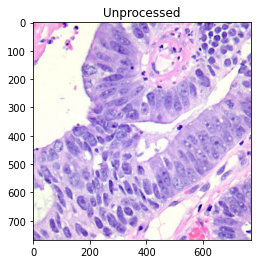

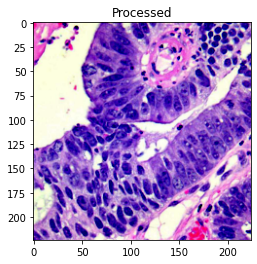

In [ ]:
x=iter(print_loader)
scan,l=x.next()
scan=scan.numpy()

unprocessed=plt.figure()
plt.imshow(np.transpose(scan[2],(1,2,0)))
plt.title('Unprocessed')

y=iter(print2_loader)
scan2,l2=y.next()
scan2=scan2.numpy()

unprocessed2=plt.figure()
plt.imshow(np.transpose(scan2[2],(1,2,0)))
plt.title('Processed')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(27, 3, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

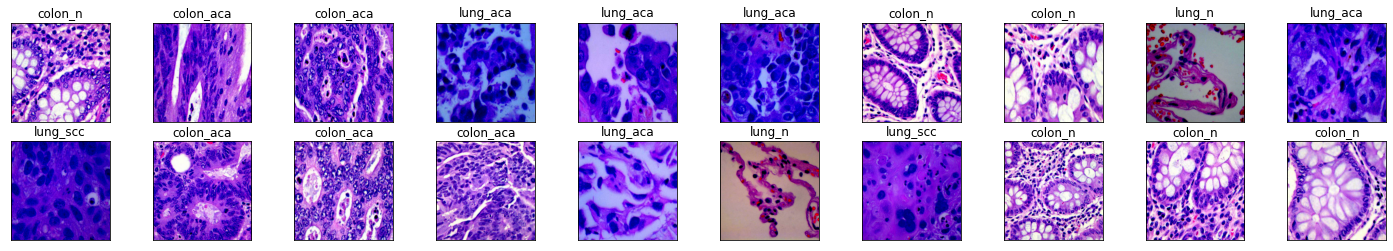

In [ ]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
print(images.shape)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])
  

# **4. Models**

In [ ]:
##############################Sheral - colon benign vs malignant#############################

In [ ]:
! mkdir /content/CNN3_ColonClassifierData
! mkdir /content/CNN3_ColonClassifierData/test
! mkdir /content/CNN3_ColonClassifierData/val
! mkdir /content/CNN3_ColonClassifierData/train

In [ ]:
! cp -r "/content/all_test/train/colon_n" "/content/CNN3_ColonClassifierData/test"
! cp -r "/content/all_test/train/colon_aca" "/content/CNN3_ColonClassifierData/test"
! cp -r "/content/output/val/colon_n" "/content/CNN3_ColonClassifierData/val"
! cp -r "/content/output/val/colon_aca" "/content/CNN3_ColonClassifierData/val"
! cp -r "/content/output/train/colon_n" "/content/CNN3_ColonClassifierData/train"
! cp -r "/content/output/train/colon_aca" "/content/CNN3_ColonClassifierData/train"

In [ ]:
data_dir = '/content/CNN3_ColonClassifierData'
train_dir = os.path.join(data_dir, 'train/')
val_dir = os.path.join(data_dir, 'val/')
test_dir = os.path.join(data_dir, 'test/')

# resize all images to 224 x 224
data_transform = transforms.Compose([transforms.Resize((224,224)), 
                                transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

colon_train_data = datasets.ImageFolder(train_dir, transform=data_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

print('Num training images: ', len(train_data))
print('Num validation images: ', len(val_data))
print('Num test images:', len(test_data))

Num training images:  17500
Num validation images:  1500
Num test images: 750


In [ ]:
# Prepare Dataloader
batch_size = 27
num_workers = 1

train3_loader = torch.utils.data.DataLoader(colon_train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

val3_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

test3_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

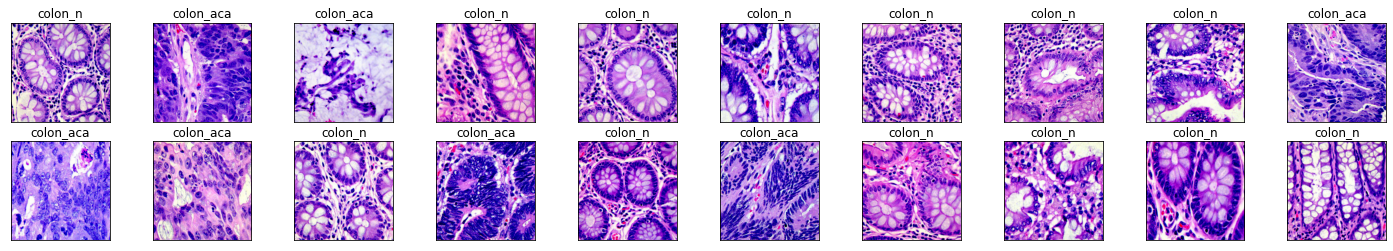

In [ ]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train3_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent

torch.manual_seed(1) # set the random seed

class CNN3_ColonClassifier(nn.Module):
  def __init__(self):
        super(CNN3_ColonClassifier, self).__init__()
        self.name="CNN3_ColonClassifier"
        self.conv1 = nn.Conv2d(3, 9 , 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(9, 10, 5)

        self.fc1 = nn.Linear(10 * 53 * 53, 200)
        self.fc2 = nn.Linear(200, 1)

  def forward(self, img):
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x=x.squeeze(1)
        return x

In [ ]:
CNN4=CNN3_ColonClassifier()
CNN4.cuda()
summary(CNN4, (3, 224, 224)) 

/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:125: UserWarning: 
Tesla T4 with CUDA capability sm_75 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the Tesla T4 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 9, 220, 220]             684
         MaxPool2d-2          [-1, 9, 110, 110]               0
            Conv2d-3         [-1, 10, 106, 106]           2,260
         MaxPool2d-4           [-1, 10, 53, 53]               0
            Linear-5                  [-1, 200]       5,618,200
            Linear-6                    [-1, 1]             201
Total params: 5,621,345
Trainable params: 5,621,345
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 5.23
Params size (MB): 21.44
Estimated Total Size (MB): 27.25
----------------------------------------------------------------


In [ ]:
##############################Elysia - colon vs lung#############################

In [ ]:
! mkdir /content/Lung_Colon_Data
! mkdir /content/Lung_Colon_Data/train
! mkdir /content/Lung_Colon_Data/train/lung
! mkdir /content/Lung_Colon_Data/train/colon
! mkdir /content/Lung_Colon_Data/test
! mkdir /content/Lung_Colon_Data/test/lung
! mkdir /content/Lung_Colon_Data/test/colon
! mkdir /content/Lung_Colon_Data/val
! mkdir /content/Lung_Colon_Data/val/lung
! mkdir /content/Lung_Colon_Data/val/colon

In [ ]:
!cp -rT '/content/output/test/lung_aca' "/content/Lung_Colon_Data/test/lung"
!cp -rT "/content/output/test/lung_scc" "/content/Lung_Colon_Data/test/lung"
!cp -rT "/content/output/test/lung_n" "/content/Lung_Colon_Data/test/lung"

!cp -rT "/content/output/val/lung_aca" "/content/Lung_Colon_Data/val/lung"
!cp -rT "/content/output/val/lung_scc" "/content/Lung_Colon_Data/val/lung"
!cp -rT "/content/output/val/lung_n" "/content/Lung_Colon_Data/val/lung"

!cp -rT "/content/output/train/lung_aca" "/content/Lung_Colon_Data/train/lung"
!cp -rT "/content/output/train/lung_scc" "/content/Lung_Colon_Data/train/lung"
!cp -rT "/content/output/train/lung_n" "/content/Lung_Colon_Data/train/lung"

!cp -rT "/content/output/test/colon_aca" "/content/Lung_Colon_Data/test/colon"
!cp -rT "/content/output/test/colon_n" "/content/Lung_Colon_Data/test/colon"

!cp -rT "/content/output/val/colon_aca" "/content/Lung_Colon_Data/val/colon"
!cp -rT "/content/output/val/colon_n" "/content/Lung_Colon_Data/val/colon"

!cp -rT "/content/output/train/colon_aca" "/content/Lung_Colon_Data/train/colon"
!cp -rT "/content/output/train/colon_n" "/content/Lung_Colon_Data/train/colon"

In [ ]:
class LungColon(nn.Module):
    def __init__(self):
        super(LungColon, self).__init__()
        self.name = "LungColon"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(10*53*53, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10*53*53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
CNN=LungColon()
CNN.cuda()
summary(CNN, (3, 224, 224)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 5, 220, 220]             380
         MaxPool2d-2          [-1, 5, 110, 110]               0
            Conv2d-3         [-1, 10, 106, 106]           1,260
         MaxPool2d-4           [-1, 10, 53, 53]               0
            Linear-5                   [-1, 32]         898,912
            Linear-6                    [-1, 1]              33
Total params: 900,585
Trainable params: 900,585
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 3.38
Params size (MB): 3.44
Estimated Total Size (MB): 7.39
----------------------------------------------------------------


In [ ]:
##############################Justin - lung classification#############################

In [ ]:
! mkdir /content/CNN2_LungClassifierData
%cd /content/CNN2_LungClassifierData/
! mkdir test
! mkdir val
! mkdir train

/content/CNN2_LungClassifierData


In [ ]:
!cp -rT "/content/output/test/lung_aca" "/content/CNN2_LungClassifierData/test/malignant" 
!cp -rT "/content/output/test/lung_scc" "/content/CNN2_LungClassifierData/test/malignant"
!cp -rT "/content/output/test/lung_n" "/content/CNN2_LungClassifierData/test/benign"

!cp -rT "/content/output/val/lung_aca" "/content/CNN2_LungClassifierData/val/malignant" 
!cp -rT "/content/output/val/lung_scc" "/content/CNN2_LungClassifierData/val/malignant"
!cp -rT "/content/output/val/lung_n" "/content/CNN2_LungClassifierData/val/benign"

!cp -rT "/content/output/train/lung_aca" "/content/CNN2_LungClassifierData/train/malignant" 
!cp -rT "/content/output/train/lung_scc" "/content/CNN2_LungClassifierData/train/malignant"
!cp -rT "/content/output/train/lung_n" "/content/CNN2_LungClassifierData/train/benign"

In [ ]:
torch.manual_seed(1) # set the random seed

class CNN2_LungClassifier(nn.Module):
    def __init__(self):
        super(CNN2_LungClassifier, self).__init__()
        self.name="CNN2_LungClassifier"
        self.conv1 = nn.Conv2d(3, 12 , 5)
        self.conv2 = nn.Conv2d(12, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.linear_layers = nn.Sequential(
            nn.Linear(10 * 53 * 53, 64),
            nn.Linear(64, 32)
        )
        self.final_fc = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.linear_layers(x))
        x = self.final_fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

CNN2 = CNN2_LungClassifier()

In [ ]:
from torchsummary import summary
CNN2.cuda()
summary(CNN2, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 220, 220]             912
         MaxPool2d-2         [-1, 12, 110, 110]               0
            Conv2d-3         [-1, 10, 106, 106]           3,010
         MaxPool2d-4           [-1, 10, 53, 53]               0
            Linear-5                   [-1, 64]       1,797,824
            Linear-6                   [-1, 32]           2,080
            Linear-7                    [-1, 1]              33
Total params: 1,803,859
Trainable params: 1,803,859
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 6.61
Params size (MB): 6.88
Estimated Total Size (MB): 14.07
----------------------------------------------------------------


In [ ]:
##############################Annalisa - lung maligant type#############################

In [ ]:
#File Organization
! mkdir /content/CNN4_LungMalignantClassifierData
! mkdir /content/CNN4_LungMalignantClassifierData/train
! mkdir /content/CNN4_LungMalignantClassifierData/val
! mkdir /content/CNN4_LungMalignantClassifierData/test

#TEST
! cp -r "/content/all_test/train/lung_aca" "/content/CNN4_LungMalignantClassifierData/test" 
! cp -r '/content/all_test/train/lung_scc' "/content/CNN4_LungMalignantClassifierData/test"

#VAL
! cp -r "/content/output/val/lung_aca" "/content/CNN4_LungMalignantClassifierData/val" 
! cp -r '/content/output/val/lung_scc' "/content/CNN4_LungMalignantClassifierData/val"

#TRAIN
! cp -r "/content/output/train/lung_aca" "/content/CNN4_LungMalignantClassifierData/train" 
! cp -r '/content/output/train/lung_scc' "/content/CNN4_LungMalignantClassifierData/train"

In [ ]:
class Lung_Malignant(nn.Module):
  def __init__(self):
    super(Lung_Malignant, self).__init__()

    self.name='l_m'

    self.layer_1=nn.Conv2d(in_channels=3,out_channels=10, kernel_size=5, stride=1,padding=1)
    self.layer_2=nn.Conv2d(in_channels=10,out_channels=15, kernel_size=4, stride=2,padding=1)
    self.layer_3=nn.Conv2d(in_channels=15,out_channels=12, kernel_size=4, stride=2,padding=1)
    self.layer_a=nn.Conv2d(in_channels=12,out_channels=10, kernel_size=4, stride=2,padding=1)

    self.pooling_1=nn.MaxPool2d(2,2)

    self.layer_4=nn.Linear(in_features=1690, out_features=200)

    self.layer_5=nn.Linear(in_features=200, out_features=1)

  
  def forward(self, data):

    lay1=torch.relu(self.layer_1(data))

    lay2=torch.relu(self.layer_2(lay1))

    lay3=torch.relu(self.layer_3(lay2))

    lay_a=torch.relu(self.layer_a(lay3))

    pool1=self.pooling_1(lay_a)

    fully_connected=pool1.view(-1,1690)

    lay4=torch.relu(self.layer_4(fully_connected))

    lay5=self.layer_5(lay4)

    lay5=lay5.squeeze(1)

    return lay5

In [ ]:
from torchsummary import summary
neural_net=Lung_Malignant()
neural_net.cuda()
summary(neural_net,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 10, 222, 222]             760
            Conv2d-2         [-1, 15, 111, 111]           2,415
            Conv2d-3           [-1, 12, 55, 55]           2,892
            Conv2d-4           [-1, 10, 27, 27]           1,930
         MaxPool2d-5           [-1, 10, 13, 13]               0
            Linear-6                  [-1, 200]         338,200
            Linear-7                    [-1, 1]             201
Total params: 346,398
Trainable params: 346,398
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 5.52
Params size (MB): 1.32
Estimated Total Size (MB): 7.41
----------------------------------------------------------------


In [ ]:
interrupt

NameError: ignored

# **5. Training and Hyperparameter Tuning**

In [ ]:
#Training Function (adapted from Lab 2)
def train_net(net, train_loader, val_loader, batch_size=150, learning_rate=0.005, num_epochs=6):
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
  
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        i=0
        for imgs, labels in iter(train_loader):
            labels = normalize_label(labels) # Convert labels to 0/1
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            # Zero the parameter gradients
            optimizer.zero_grad()
            #print(imgs.shape)
            # Forward pass, backward pass, and optimize
            outputs = net(imgs)
            #print(labels.float())
            #print(outputs.shape)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
            i=i+1
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [ ]:
##############################Sheral- colon benign vs malignant#############################

In [ ]:
##Best Hyper Params
model = CNN3_ColonClassifier()

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
train_net(model, train3_loader, val3_loader, batch_size=256, learning_rate=0.001, num_epochs=20)

In [ ]:
model_path = get_model_name("CNN3_ColonClassifier", batch_size=256, learning_rate=0.001, epoch=19)
state = torch.load(model_path)
model.load_state_dict(state)

In [ ]:
plot_training_curve(model_path)

In [ ]:
evaluate(model, test3_loader, nn.BCEWithLogitsLoss())

In [ ]:
#### Elysia - Lung vs Colon

In [ ]:
data_all = '/content/Lung_Colon_Data'
train_all = os.path.join(data_all, 'train/')
val_all = os.path.join(data_all, 'val/')
test_all = os.path.join(data_all, 'test')

data_transform_all = transforms.Compose([transforms.Resize((224,224)), 
                                transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data_all = datasets.ImageFolder(train_all, transform=data_transform_all)
val_data_all = datasets.ImageFolder(val_all, transform=data_transform_all)
test_data_all = datasets.ImageFolder(test_all, transform=data_transform_all)

print('Num training images: ', len(train_data_all))
print('Num validation images: ', len(val_data_all))
print('Num test images:', len(test_data_all))

Num training images:  17500
Num validation images:  3750
Num test images: 3750


In [ ]:
batch_size2 = 256
num_workers2 = 1

train_loader_all = torch.utils.data.DataLoader(train_data_all, batch_size=batch_size2, 
                                           num_workers=num_workers2, shuffle=True)

val_loader_all = torch.utils.data.DataLoader(val_data_all, batch_size=batch_size2, 
                                           num_workers=num_workers2, shuffle=True)

test_loader_all = torch.utils.data.DataLoader(test_data_all, batch_size=batch_size2, 
                                           num_workers=num_workers2, shuffle=True)

In [ ]:
model_all =  LungColon()

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model_all.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_net_all(model_all, train_loader_all, val_loader_all, 256, 0.1, 5)

In [ ]:
#model_path = get_model_name("LungColon", batch_size=256, learning_rate=0.001, epoch=9)
plot_training_curve('model_LungColon_bs256_lr0.01_epoch4')

In [ ]:
CNN1=LungColon()
CNN1=Model_Loader(CNN1,'/content/model_LungColon_bs256_lr0.001_epoch14')

/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:125: UserWarning: 
Tesla T4 with CUDA capability sm_75 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the Tesla T4 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


In [ ]:
use_cuda=True
print(evaluate(CNN1,test_loader_all,nn.BCEWithLogitsLoss()))

(0.0048, 0.012934621423482895)


In [ ]:
#############################Justin -- Lung b vs m#############################

In [ ]:
data_dir2 = '/content/CNN2_LungClassifierData'
train_dir2 = os.path.join(data_dir2, 'train/')
val_dir2 = os.path.join(data_dir2, 'val/')
test_dir2 = os.path.join(data_dir2, 'test')

data_transform2 = transforms.Compose([transforms.Resize((224,224)), 
                                transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data2 = datasets.ImageFolder(train_dir2, transform=data_transform2)
val_data2 = datasets.ImageFolder(val_dir2, transform=data_transform2)
test_data2 = datasets.ImageFolder(test_dir2, transform=data_transform2)

print('Num training images: ', len(train_data2))
print('Num validation images: ', len(val_data2))
print('Num test images:', len(test_data2))

In [ ]:
# Prepare Dataloader
batch_size2 = 256
num_workers2 = 1

train_loader2 = torch.utils.data.DataLoader(train_data2, batch_size=batch_size2, 
                                           num_workers=num_workers2, shuffle=True)

val_loader2 = torch.utils.data.DataLoader(val_data2, batch_size=batch_size2, 
                                           num_workers=num_workers2, shuffle=True)

test_loader2 = torch.utils.data.DataLoader(test_data2, batch_size=batch_size2, 
                                           num_workers=num_workers2, shuffle=True)

In [ ]:
model2 = CNN2_LungClassifier()

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model2.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
#print(labels.float()) 
train_net(model2, train_loader2, val_loader2, 256, 0.01, 15)

In [ ]:
plot_training_curve(get_model_name(CNN2_LungClassifier().name, 256, 0.01, 14))

In [ ]:
use_cuda=True
net = CNN2_LungClassifier()
model_path = get_model_name(net.name, batch_size=150, learning_rate=0.01, epoch=9)
state = torch.load(model_path)
net.load_state_dict(state)
net = net.cuda()

evaluate(net, test_loader2, nn.BCEWithLogitsLoss)

In [ ]:
#############################Annalisa -- Malignant Lung types#############################

In [ ]:

reshape=transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
mlung_tr=datasets.ImageFolder('/content/CNN4_LungMalignantClassifierData/train', transform=reshape)
mlung_v=datasets.ImageFolder('/content/CNN4_LungMalignantClassifierData/val', transform=reshape)
mlung_ts=datasets.ImageFolder('/content/CNN4_LungMalignantClassifierData/test', transform=reshape)

lm_train_loader=torch.utils.data.DataLoader(mlung_tr, batch_size=64, num_workers=0, shuffle=True)
lm_val_loader=torch.utils.data.DataLoader(mlung_v, batch_size=64, num_workers=0, shuffle=True)
lm_test_loader=torch.utils.data.DataLoader(mlung_ts, batch_size=64, num_workers=0, shuffle=True)

In [ ]:
lung_malignant_final=Lung_Malignant()

use_cuda=True
if torch.cuda.is_available():
  lung_malignant_final.cuda()

In [ ]:
#training
train_net(lung_malignant_final, lm_train_loader, lm_val_loader, batch_size=64, learning_rate=0.0065, num_epochs=13)
lm_path=get_model_name('l_m', 64, 0.0065, 12)
plot_training_curve(lm_path)     

In [ ]:
###TESTING
evaluate(lung_malignant_final, lm_test_loader, nn.BCEWithLogitsLoss())

# Connecting Models

In [ ]:
############################## Connecting Models ########################################

In [ ]:
def all_models(data,CNN1,CNN2,CNN3,CNN4):
  for images,labels in data:
    for element, lab in zip(images,labels):
      res=""
      element=element.unsqueeze(0)
      out1=torch.sigmoid(CNN1(element.cuda()))
      #print(out1, lab)
      if out1[0]>0.5:
        #res=("Lung")
        out2=torch.sigmoid(CNN2(element.cuda()))
        if out2[0]<0.5:
          res= "Lung: benign"
        else:
          #res = "Lung: malignant"
          out4=torch.sigmoid(CNN4(element.cuda()))
          #print(out4[0],lab)
          if out4[0]<0.5:
            res = "Lung: malignant: aca"
          else:
           res = "Lung: malignant: scc"
      else:
        #print("colon")
        out3=torch.sigmoid(CNN3(element.cuda()))
        if out3[0]<0.5:
          res = "Colon: benign"
        else:
          res = "Colon: malignant"
      print(res)

In [ ]:
def single_image_checker(img_path,CNN1,CNN2,CNN3,CNN4):
      element = image_loader(sample_image_path)
      res=""
      element=element.unsqueeze(0)
      out1=torch.sigmoid(CNN1(element.cuda()))
      #print(out1, lab)
      if out1[0]<1:
        #res=("Lung")
        out2=torch.sigmoid(CNN2(element.cuda()))
        if out2[0]<0.5:
          res= "Lung: benign"
        else:
          #res = "Lung: malignant"
          out4=torch.sigmoid(CNN4(element.cuda()))
          #print(out4[0],lab)
          if out4[0]<0.5:
            res = "Lung: malignant: aca"
          else:
           res = "Lung: malignant: scc"
      else:
        #print("colon")
        out3=torch.sigmoid(CNN3(element.cuda()))
        if out3[0]<0.5:
          res = "Colon: benign"
        else:
          res = "Colon: malignant"
      print(res)

In [ ]:
def connect_accuracy(data,CNN1,CNN2,CNN3,CNN4,print_img=False):
  total=0
  corr=0


  false_n_p=np.array([["pred |label","ca","cn","la","ln","ls"],
                    ["colon_aca", 0, 0, 0, 0, 0],
                    ["colon_n. ", 0, 0, 0, 0, 0],
                    ["lung_aca ", 0, 0, 0, 0, 0],
                    ["lung_n.  ", 0, 0, 0, 0, 0],
                    ["lung_scc ", 0, 0, 0, 0, 0]
                    ])

  for images,labels in data:
    for element, lab in zip(images,labels):
      #print("Lab: "+str(lab))
      lab=int(lab)
      label_string=''
      pred_string=''

      ########################
      if print_img==True:  
        p=element.numpy()
        print_plot=plt.figure()
        p=np.transpose(p,(1,2,0))
        plt.imshow(p)
        #######################



      classes = ['colon_aca', 'colon_n', 'lung_aca','lung_n', 'lung_scc']
      element=element.unsqueeze(0)
      out1=torch.sigmoid(CNN1(element.cuda()))
 
      if out1[0]>0.5:  #1 is lung, 0 is colon
        #print('lung:')
        out2=torch.sigmoid(CNN2(element.cuda()))

        if out2[0]<0.5: #0 is benign, 1 is malignant
          #print('benign')
          res= 3

        else:
          #res = "Lung: malignant"
          out4=torch.sigmoid(CNN4(element.cuda()))
          #print(out4[0],lab)
          if out4[0]<0.5: #0 is aca, 1 is scc
            #print('aca')
            res = 2
          else:
            #print('scc')
            res = 4

      else:
        #print(out1[0])
        #print('colon:')
        out3=torch.sigmoid(CNN3(element.cuda()))
        if out3[0]<0.5: #0 is malignant, 1 is benign
          res = 0
          #print(out3[0])
          #print('malignant')

        else:
          res = 1
          #print('benign')

      label_string=classes[lab]
      pred_string=classes[res]
      ########################################################
      if print_img==True:
        plt.title('Label: '+label_string+" | Pred: "+pred_string)
        
      ########################################################

      false_n_p[res+1,lab+1]=int(false_n_p[res+1,lab+1])+1
      total+=1
      if res==lab:
          corr+=1

      

  print(false_n_p)
  print("correct:",corr,", total:",total,", accuracy:",corr/total)

In [ ]:
def Model_Loader(net, model_path):
  state=torch.load(model_path)
  net.load_state_dict(state)
  net = net.cuda()
  return net

In [ ]:
CNN1=LungColon()
CNN1=Model_Loader(CNN1,'/content/model_LungColon_bs256_lr0.001_epoch14')

CNN2=CNN2_LungClassifier()
CNN2=Model_Loader(CNN2,'/content/model_CNN2_LungClassifier_bs150_lr0.01_epoch9')

CNN3=CNN3_ColonClassifier()
CNN3=Model_Loader(CNN3,'/content/model_CNN3_ColonClassifier_bs256_lr0.001_epoch14')

CNN4=Lung_Malignant()
CNN4= Model_Loader(CNN4,'/content/model_l_m_bs64_lr0.0065_epoch12')


In [ ]:
###DEMO###
#Demo images from testing set
! mkdir /content/DEMO
#COLON ACA
! mkdir /content/DEMO/colon_aca

img1='/content/all_test/val/colon_aca/colonca1.jpeg'
img2='/content/all_test/val/colon_aca/colonca101.jpeg'

! mv '/content/all_test/val/colon_aca/colonca1.jpeg' '/content/DEMO/colon_aca' 
! mv '/content/all_test/val/colon_aca/colonca101.jpeg' '/content/DEMO/colon_aca'

#COLON BENIGN
! mkdir /content/DEMO/colon_n

img3='/content/all_test/val/colon_n/colonn1.jpeg'
img4='/content/all_test/val/colon_n/colonn101.jpeg'

! mv '/content/all_test/val/colon_n/colonn1.jpeg' '/content/DEMO/colon_n' 
! mv '/content/all_test/val/colon_n/colonn101.jpeg' '/content/DEMO/colon_n' 


#LUNG ACA
! mkdir /content/DEMO/lung_aca

img5='/content/all_test/val/lung_aca/lungaca1.jpeg'
img6='/content/all_test/val/lung_aca/lungaca101.jpeg'

! mv '/content/all_test/val/lung_aca/lungaca1.jpeg' '/content/DEMO/lung_aca' 
! mv '/content/all_test/val/lung_aca/lungaca101.jpeg' '/content/DEMO/lung_aca' 

#LUNG BENIGN
! mkdir /content/DEMO/lung_n

img7='/content/all_test/val/lung_n/lungn1.jpeg'
img8='/content/all_test/val/lung_n/lungn101.jpeg'

! mv '/content/all_test/val/lung_n/lungn1.jpeg' '/content/DEMO/lung_n' 
! mv '/content/all_test/val/lung_n/lungn101.jpeg' '/content/DEMO/lung_n' 

#LUNG SCC
! mkdir /content/DEMO/lung_scc

img9='/content/all_test/val/lung_scc/lungscc1.jpeg'
img10='/content/all_test/val/lung_scc/lungscc101.jpeg'

! mv '/content/all_test/val/lung_scc/lungscc1.jpeg' '/content/DEMO/lung_scc' 
! mv '/content/all_test/val/lung_scc/lungscc101.jpeg' '/content/DEMO/lung_scc' 



In [ ]:
train_dir='/content/output/train'
data_transform2 = transforms.Compose([transforms.Resize((224,224)), 
                                transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_data = datasets.ImageFolder(train_dir, transform=data_transform2)
batch_size = 27
num_workers = 1

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=False)

In [ ]:
demo_path = '/content/DEMO'
demo_data = datasets.ImageFolder(demo_path, transform=with_norm)
demo_loader = torch.utils.data.DataLoader(demo_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

test_path_final='/content/all_test/val'
test_data = datasets.ImageFolder(test_path_final, transform=with_norm)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

In [ ]:
interrupt

NameError: ignored

# **6. Testing**

In [ ]:
######TESTING#####
connect_accuracy(test_loader,CNN1,CNN2,CNN3,CNN4,print_img=False)

In [ ]:
interrupt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[['pred |label' 'ca' 'cn' 'la' 'ln' 'ls']
 ['colon_aca' '2' '0' '0' '0' '0']
 ['colon_n. ' '0' '2' '0' '0' '0']
 ['lung_aca ' '0' '0' '1' '0' '0']
 ['lung_n.  ' '0' '0' '0' '2' '0']
 ['lung_scc ' '0' '0' '1' '0' '2']]
correct: 9 , total: 10 , accuracy: 0.9


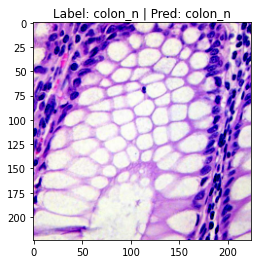

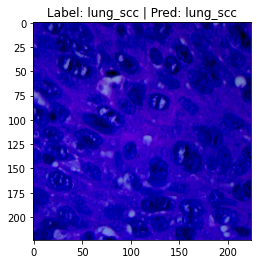

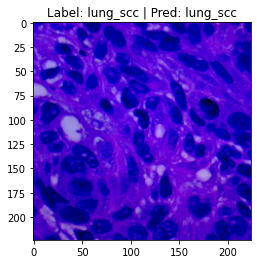

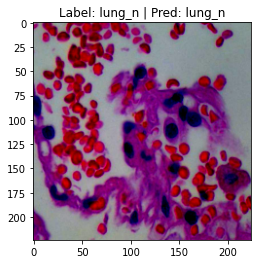

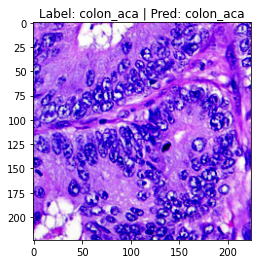

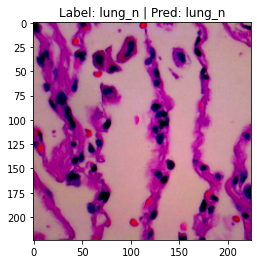

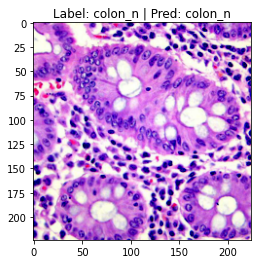

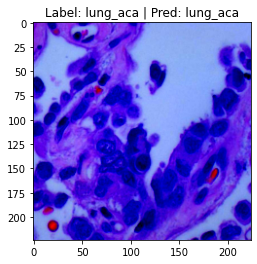

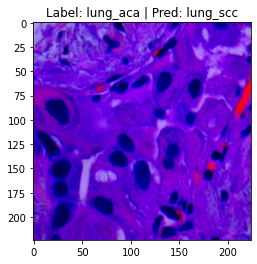

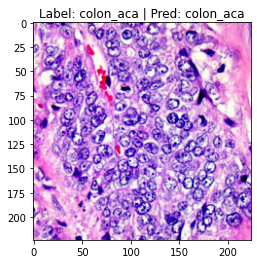

In [ ]:
######DEMO#######
connect_accuracy(demo_loader,CNN1,CNN2,CNN3,CNN4,print_img=True) #10 images

In [ ]:
interrupt

In [ ]:
#connect_accuracy(colbenign_loader,CNN1,CNN2,CNN3,CNN4)

In [ ]:
#connect_accuracy(colmal_loader,CNN1,CNN2,CNN3,CNN4)

In [ ]:
#connect_accuracy(lungscc_loader,CNN1,CNN2,CNN3,CNN4)

In [ ]:
#connect_accuracy(lungaca_loader,CNN1,CNN2,CNN3,CNN4)

In [ ]:
#connect_accuracy(lungbenign_loader,CNN1,CNN2,CNN3,CNN4)

In [ ]:
#data_transform2 = transforms.Compose([transforms.Resize((224,224)), 
                                #transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#img_path = '/content/all_test/train/colon_n/colonn10.jpeg'
#predict(CNN1, '/content/model_LungColon_bs256_lr0.001_epoch22', img_path)

In [ ]:
#use_cuda=True
#i=1
#m=m = torch.sigmoid()
#for imgs, labels in iter(val4_loader):
#  labels = normalize_label(labels) # Convert labels to 0/1
#  if use_cuda and torch.cuda.is_available():
#            imgs = imgs.cuda()
#            labels = labels.cuda()
#            print(labels)
#            outputs = net(imgs)
#            pred=m(output)
#            print(pred)
#            break

In [ ]:
def image_loader(image_name):
    """
    Load image and prepares it for model.
    
    Args:
        image_name: string representing path of image location
    Returns:
        image.cuda: CUDA tensor
    """
    image = Image.open(image_name)
    image = data_transform2(image).float()
    image = image.unsqueeze(0)
    image = Variable(image)
    return image.cuda()

def predict(net, model_path, sample_image_path):
    """
    Predicts output given a trained neural net model and an image.

    Args:
        net -> PyTorch neural network object
        model_path -> return value from get_model_name()
        sample_image_path -> return value from image_loader()

    Returns:
        tensor: CUDA tensor object

    >>> net = CNN2_LungClassifier()
    >>> model_path = get_model_name(net.name, batch_size=150, learning_rate=0.01, epoch=9)
    >>> img_path = '/content/CNN2_LungClassifierData/test/benign/lungn1019.jpeg'
    >>> predict(net, model_path, img_path)

    Console: 
        tensor([0.0005], device='cuda:0', grad_fn=<SigmoidBackward>) -> Prediction: Class 0 (Benign)
    """
    state = torch.load(model_path)
    net.load_state_dict(state)
    net = net.cuda()
    img = image_loader(sample_image_path)
    x = net(img)
    return torch.sigmoid(x)

In [ ]:
#sample images

In [ ]:
net = CNN2_LungClassifier()
model_path = '/content/model_CNN2_LungClassifier_bs150_lr0.01_epoch9'
img_path='/content/CNN2_LungClassifierData/train/benign/lungn1002.jpeg'
#img_path = '/content/CNN2_LungClassifierData/test/malignant/lungaca10.jpeg'
predict(net, model_path, img_path)

In [ ]:
net = CNN3_ColonClassifier()
model_path = '/content/model_CNN3_ColonClassifier_bs256_lr0.001_epoch14'
img_path='/content/CNN3_ColonClassifierData/train/colon_aca/colonca1002.jpeg'
#img_path = '/content/CNN3_ColonClassifierData/test/colon_n/colonn1174.jpeg'
predict(net, model_path, img_path)

In [ ]:
net = LungColon()
model_path = '/content/model_LungColon_bs256_lr0.001_epoch14'
img_path='/content/Lung_Colon_Data/train/colon/colonca1002.jpeg'
#img_path = '/content/Lung_Colon_Data/test/lung/lungaca1014.jpeg'
predict(net, model_path, img_path)

In [ ]:
net=Lung_Malignant()
model_path='/content/model_l_m_bs64_lr0.0065_epoch12'
img_path='/content/CNN4_LungMalignantClassifierData/train/lung_aca/lungaca1002.jpeg'
predict(net, model_path, img_path)

# **7. Baseline Model**

In [ ]:
###Dataloading
reshape=transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

random_forests=datasets.ImageFolder('/content/output/train', transform=reshape)
random_forests_val=datasets.ImageFolder('/content/output/val', transform=reshape)

random_forests_loader=torch.utils.data.DataLoader(random_forests, batch_size=1, num_workers=0, shuffle=True)
random_forests_val_loader=torch.utils.data.DataLoader(random_forests_val, batch_size=1, num_workers=0, shuffle=True)

In [ ]:
use_cuda=True
l=len(random_forests_loader)
i_max=7000 #number of training images
training_tensor=np.zeros((i_max,224*224))
labels_tensor=np.zeros((i_max,1))
i=0



for images,labels in iter(random_forests_loader):
  
  images=images.squeeze(0)[0]
  images=images.reshape(-1, 224*224)

  training_tensor[i]=images
  labels_tensor[i]=labels
  i=i+1
  print((i/i_max)*100)
  if i==i_max:
    break



In [ ]:
from sklearn.ensemble import RandomForestClassifier
cancer_classifier= RandomForestClassifier(n_estimators=1000)

cancer_classifier.fit(training_tensor, labels_tensor) #<-- only run .fit once

In [ ]:

v=0
v_max=1000
total=0
corr=0

false_n_p=np.array([["pred |label","ca","cn","la","ln","ls"],
                    ["colon_aca", 0, 0, 0, 0, 0],
                    ["colon_n. ", 0, 0, 0, 0, 0],
                    ["lung_aca ", 0, 0, 0, 0, 0],
                    ["lung_n.  ", 0, 0, 0, 0, 0],
                    ["lung_scc ", 0, 0, 0, 0, 0]
                    ])

for images,labels in iter(random_forests_val_loader):
  images=images.squeeze(0)[0]
  images=images.reshape(-1, 224*224)
  v=v+1
  total=total+1

  est=cancer_classifier.predict(images)
  est=int(est)
  print('Estimate')
  print(est)
  labels=int(labels)
  print('Label')
  print(labels)
  if est==labels:
    corr=corr+1
  #False Positive/Negative
  print(est+1)
  print(labels+1)
  false_n_p[est+1,labels+1]=int(false_n_p[est+1,labels+1])+1
  print(false_n_p)






  if v==v_max:
    break

  
val_accuracy=corr/total
print('val acc:')
print(val_accuracy)
